### SeaFlow data (regridded)

In [1]:
using NetCDF, StanSample, PyPlot, Statistics, PyCall, Interpolations

In [2]:
### load data
data_seaflow = Dict("time" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","time",start=[1],count=[-1]),
                    "size_bounds" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","size_bounds",start=[1],count=[-1]),
                    "w_obs" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","w_obs",start=[1,1],count=[-1,-1]),
                    "PAR" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","PAR",start=[1],count=[-1]),
                    "m" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","m")[1],
                    "v_min" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","v_min")[1],
                    "delta_v_inv" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","delta_v_inv")[1])

Dict{String,Any} with 7 entries:
  "size_bounds" => [0.0135, 0.0155074, 0.0178134, 0.0204622, 0.0235049, 0.027, …
  "time"        => [0, 3, 6, 9, 12, 15, 18, 21, 24, 27  …  5729, 5732, 5735, 57…
  "w_obs"       => [0.018937 0.0755286 … 0.000536307 0.000130877; 0.0188122 0.0…
  "PAR"         => [1987.91, 2137.93, 1981.03, 1967.0, 2041.37, 2054.12, 2030.1…
  "m"           => 15
  "v_min"       => 0.0135
  "delta_v_inv" => 5

In [3]:
v_min = data_seaflow["v_min"]
delta_v = 1.0/data_seaflow["delta_v_inv"]
v = v_min .* 2 .^(collect(0:1:data_seaflow["m"]-1)*delta_v);

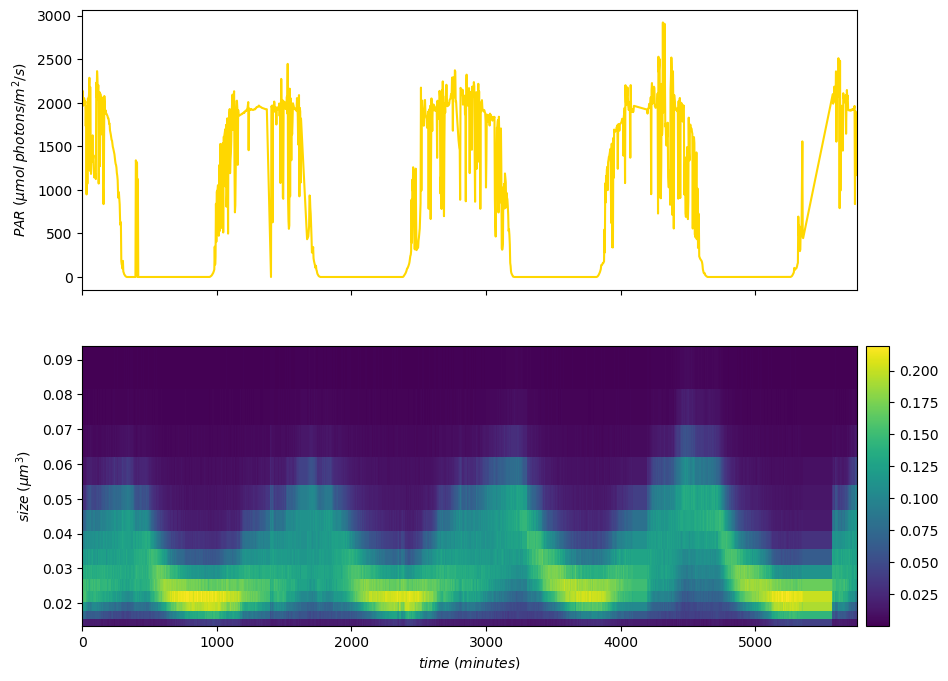

In [4]:
inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
fig,axs = plt.subplots(nrows=2, sharex=true, figsize=(10,8))
axs[1].plot(data_seaflow["time"], data_seaflow["PAR"], color="gold")
axs[1].set(ylabel=L"PAR\;(\mu mol\;photons/m^{2}/s)")
pc = axs[2].pcolormesh(data_seaflow["time"],v,reverse(rotl90(data_seaflow["w_obs"]),dims=1))
axs[2].set(ylabel=L"size\;(\mu m^3)", xlabel=L"time\;(minutes)")
pcb = inset_locator.inset_axes(axs[2], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[2].transAxes)
fig.colorbar(pc,cax=pcb, pad = 0.02);

### The model
modified from Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.

In [142]:
tmpdir=mktempdir()

"/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_qTki8T"

In [197]:
stan_code1 = """data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;   // inverse of delta_v 
    simplex[m] w_ini;       // initial conditions 
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    real<lower=0> obs[m,nt_obs]; // observations
}
transformed data {
    int j;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> v[m];     // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    for (i in 1:m){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> delta_mu; 
    real<lower=0> delta_sigma; 
    real<lower=0> delta_max[m-j+1,6]; 
    real<lower=0> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma; 
}
transformed parameters {
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr; 
        vector[m] w_next;
        real delta_i = 0.0;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        int ith = 1;
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            // compute gamma
            gamma = gamma_max * dt_days * (1.0 - exp(-E[it]/E_star));
            w_next = rep_vector(0.0, m);
            for (i in 1:m){ // size-class loop
                // compute delta_i
                if (i >= j){
                    delta_i = delta_max[i-j+1,ith] * dt_days;
                }
                
                // fill subdiagonal (growth)
                if (i < j){
                    //A[i+1,i] = gamma;
                    a = gamma;
                    w_next[i+1] += a * w_curr[i];
                } else if (i < m){
                    //A[i+1,i] = gamma * (1.0-delta_i);
                    a = gamma * (1.0-delta_i);
                    w_next[i+1] += a * w_curr[i];
                }
                // fill (j-1)th superdiagonal (division)
                if (i >= j){
                    //A[i+1-j,i] = 2.0*delta_i;
                    a = 2.0*delta_i;
                    w_next[i+1-j] += a * w_curr[i];
                }
                // fill diagonal (stasis)
                if (i < j){
                    //A[i,i] = (1.0-gamma);
                    a = (1.0-gamma);
                    w_next[i] += a * w_curr[i];
                } else if (i == m){
                    //A[i,i] = (1.0-delta_i);
                    a = (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                } else {
                    //A[i,i] = (1.0-gamma) * (1.0-delta_i);
                    a = (1.0-gamma) * (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                }
            }
            w_curr = w_next ./ sum(w_next);
            ith = 1;
            while(ith*240<t[it]%1440){
                ith += 1;
            }
        }
    }
}
model {
    real diff;
    
    // priors
    delta_mu ~ normal(66.0, 1.0);
    delta_sigma ~ normal(5.0, 1.0);
    for (im in 1:6){
        delta_max[,im] ~ normal(delta_mu, delta_sigma); // T[0.0,1440.0/dt];
    }
    gamma_max ~ uniform(0.0,1440.0/dt);
    E_star ~ normal(3000.0,10.0);
    sigma ~ exponential(1000.0);

    // fitting observations
    for (it in 1:nt_obs){
        diff = 0.0;
        for (iv in 1:m){
            diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
        }
        diff = diff/sigma;
        diff ~ normal(0.0, 1.0) T[0,];
    }
}
""";

In [198]:
### prepare data for stan model
dt = 20 # in units of minutes
data = Dict("dt" => dt,
            "m" => data_seaflow["m"],
            "v_min" => data_seaflow["v_min"],
            "delta_v_inv" => data_seaflow["delta_v_inv"],
            "obs" => data_seaflow["w_obs"],
            "t_obs" => data_seaflow["time"],
            "E" => data_seaflow["PAR"],
            "w_ini" => data_seaflow["w_obs"][1,:], # use first measurements as initial conditions
            "nt" => 2*1440÷dt,
            "nt_obs" => length(data_seaflow["time"]))

limit_to_numdays = 2.0
stride_t_obs = 20

itp = interpolate((data["t_obs"],), data["E"], Gridded(Linear()));
data["E"] = itp(collect(1:1:data["nt"])*data["dt"])

ind_obs = findall(x -> x>3, data["t_obs"]);
data["t_obs"] = data["t_obs"][ind_obs];
data["obs"] = data["obs"][ind_obs,:];

if limit_to_numdays > 0
    thresh = limit_to_numdays*1440
    ind_obs = findall(x -> x<thresh, data["t_obs"])
    data["t_obs"] = data["t_obs"][ind_obs]
    data["obs"] = data["obs"][ind_obs,:]
    data["nt"] = Int(thresh÷data["dt"])
end

if stride_t_obs > 0
    data["t_obs"] = data["t_obs"][collect(1:stride_t_obs:length(data["t_obs"]))]
    data["obs"] = data["obs"][collect(1:stride_t_obs:size(data["obs"],1)),:];
end
data["nt_obs"] = size(data["t_obs"],1)
data["obs"] = reverse(rotl90(data["obs"]),dims=1);

In [199]:
sm = SampleModel("MatrixModel", stan_code1,tmpdir = tmpdir)


/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_qTki8T/MatrixModel.stan updated.


  name =                    "MatrixModel"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_qTki8T"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [200]:
(sample_file, log_file) = stan_sample(sm, data=data, n_chains = 4);

In [201]:
chns = read_samples(sm);

In [202]:
ESS = ess(chns)

ESS

│ Row │ parameters       │ ess     │ r_hat    │
│     │ Symbol           │ Any     │ Any      │
├─────┼──────────────────┼─────────┼──────────┤
│ 1   │ delta_mu         │ 440.304 │ 1.01232  │
│ 2   │ delta_sigma      │ 339.179 │ 1.01527  │
│ 3   │ delta_max.1.1    │ 194.465 │ 1.01107  │
│ 4   │ delta_max.2.1    │ 183.84  │ 1.01746  │
│ 5   │ delta_max.3.1    │ 157.178 │ 1.04104  │
│ 6   │ delta_max.4.1    │ 245.368 │ 1.05162  │
│ 7   │ delta_max.5.1    │ 280.742 │ 1.01804  │
│ 8   │ delta_max.6.1    │ 377.647 │ 1.0102   │
│ 9   │ delta_max.7.1    │ 198.787 │ 1.03046  │
│ 10  │ delta_max.8.1    │ 537.344 │ 1.00475  │
│ 11  │ delta_max.9.1    │ 190.328 │ 1.01448  │
│ 12  │ delta_max.10.1   │ 187.409 │ 1.01918  │
│ 13  │ delta_max.1.2    │ 399.705 │ 1.00748  │
│ 14  │ delta_max.2.2    │ 279.506 │ 1.0186   │
│ 15  │ delta_max.3.2    │ 421.267 │ 1.01243  │
│ 16  │ delta_max.4.2    │ 572.223 │ 1.00645  │
│ 17  │ delta_max.5.2    │ 360.962 │ 1.01019  │
│ 18  │ delta_max.6.2    │ 356.182 

In [210]:
rawdata = DataFrame(chns, showall=true, sorted=true, append_chains=true);

In [215]:
deltas = Matrix(rawdata[:,2:61])
#rawdata[:,2:461]
deltas = reshape(deltas,4000,6,10);

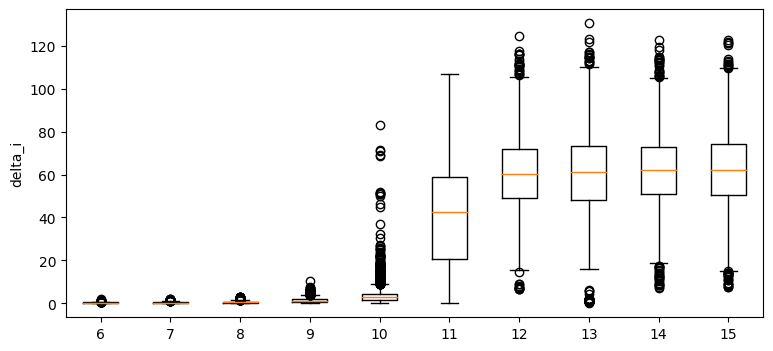

In [244]:
fig, ax = PyPlot.subplots(figsize=(9,4))
ax.boxplot(deltas[:,2,:], positions=collect(6:1:15))
ax.set(ylabel="delta_i");
#ax.yaxis.grid(true)

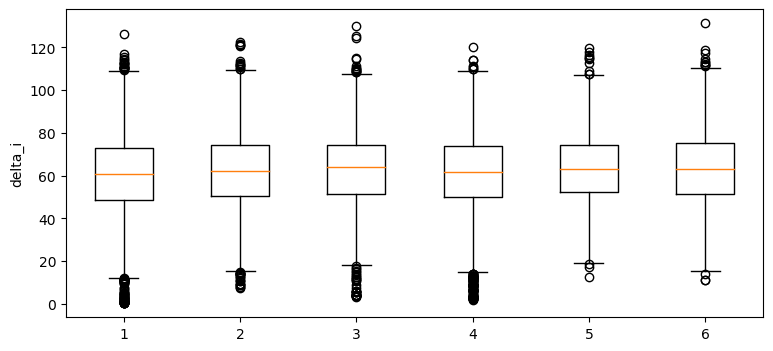

In [243]:
fig, ax = PyPlot.subplots(figsize=(9,4))
ax.boxplot(deltas[:,:,10], positions=collect(1:1:6))
ax.set(ylabel="delta_i");
#ax.yaxis.grid(true)

In [223]:
chns

Object of type Chains, with data of type 1000×762×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = delta_mu, delta_sigma, delta_max.1.1, delta_max.2.1, delta_max.3.1, delta_max.4.1, delta_max.5.1, delta_max.6.1, delta_max.7.1, delta_max.8.1, delta_max.9.1, delta_max.10.1, delta_max.1.2, delta_max.2.2, delta_max.3.2, delta_max.4.2, delta_max.5.2, delta_max.6.2, delta_max.7.2, delta_max.8.2, delta_max.9.2, delta_max.10.2, delta_max.1.3, delta_max.2.3, delta_max.3.3, delta_max.4.3, delta_max.5.3, delta_max.6.3, delta_max.7.3, delta_max.8.3, delta_max.9.3, delta_max.10.3, delta_max.1.4, delta_max.2.4, delta_max.3.4, delta_max.4.4, delta_max.5.4, delta_max.6.4, delta_max.7.4, delta_max.8.4, delta_max.9.4, delta_max.10.4, delta_max.1.5, delta_max.2.5, delta_max.3.5, delta_max.4.5, delta_max.5.5, d

In [255]:
deltas_m = reshape(chns.info[1].x[2][1][3:62,2],10,6)

10×6 Array{Float64,2}:
  1.61912   0.266393   0.362593   0.871027   3.57971   4.08737
  3.35805   0.399187   1.69279    3.12985    9.34622   5.62207
  2.71476   0.518706   5.93438   52.333     21.99      6.68127
  6.41306   1.26214   33.1462    60.8462    49.993    16.4316 
  6.71293   3.64545   49.8603    61.5257    58.7562   37.3989 
 15.6763   40.9536    62.1567    61.2369    62.303    56.6394 
 44.7264   60.3338    62.0405    60.0546    62.0625   60.0858 
 61.091    60.8677    62.0101    60.4408    64.0284   61.5758 
 61.7353   62.2083    60.4318    61.0592    61.3144   60.5796 
 60.4494   62.5169    63.0161    61.2926    63.1038   63.0404 

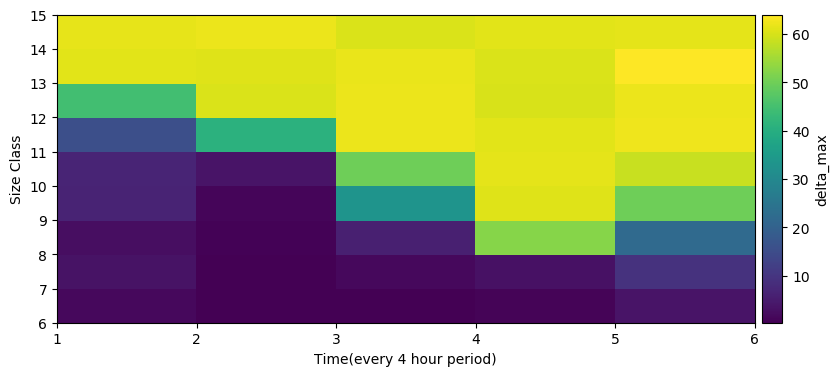

1-element Array{PyObject,1}:
 PyObject Text(0.5, 24.0, 'Time(every 4 hour period)')

In [262]:
fig, ax = PyPlot.subplots(figsize=(9,4))
p1 = ax.pcolormesh(collect(1:1:6),collect(6:1:15),deltas_m);
p1b = inset_locator.inset_axes(ax, width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
fig.colorbar(p1,cax=p1b, pad = 0.02,label="delta_max");
ax.set(ylabel="Size Class")
ax.set(xlabel="Time(every 4 hour period)")

In [261]:
res = Dict("model" => reshape(chns.info[1].x[2][1][66:755,2],15,46), "obs" => data["obs"])
diff = res["model"]-res["obs"];
t = collect(1:1:data["nt"])*data["dt"];

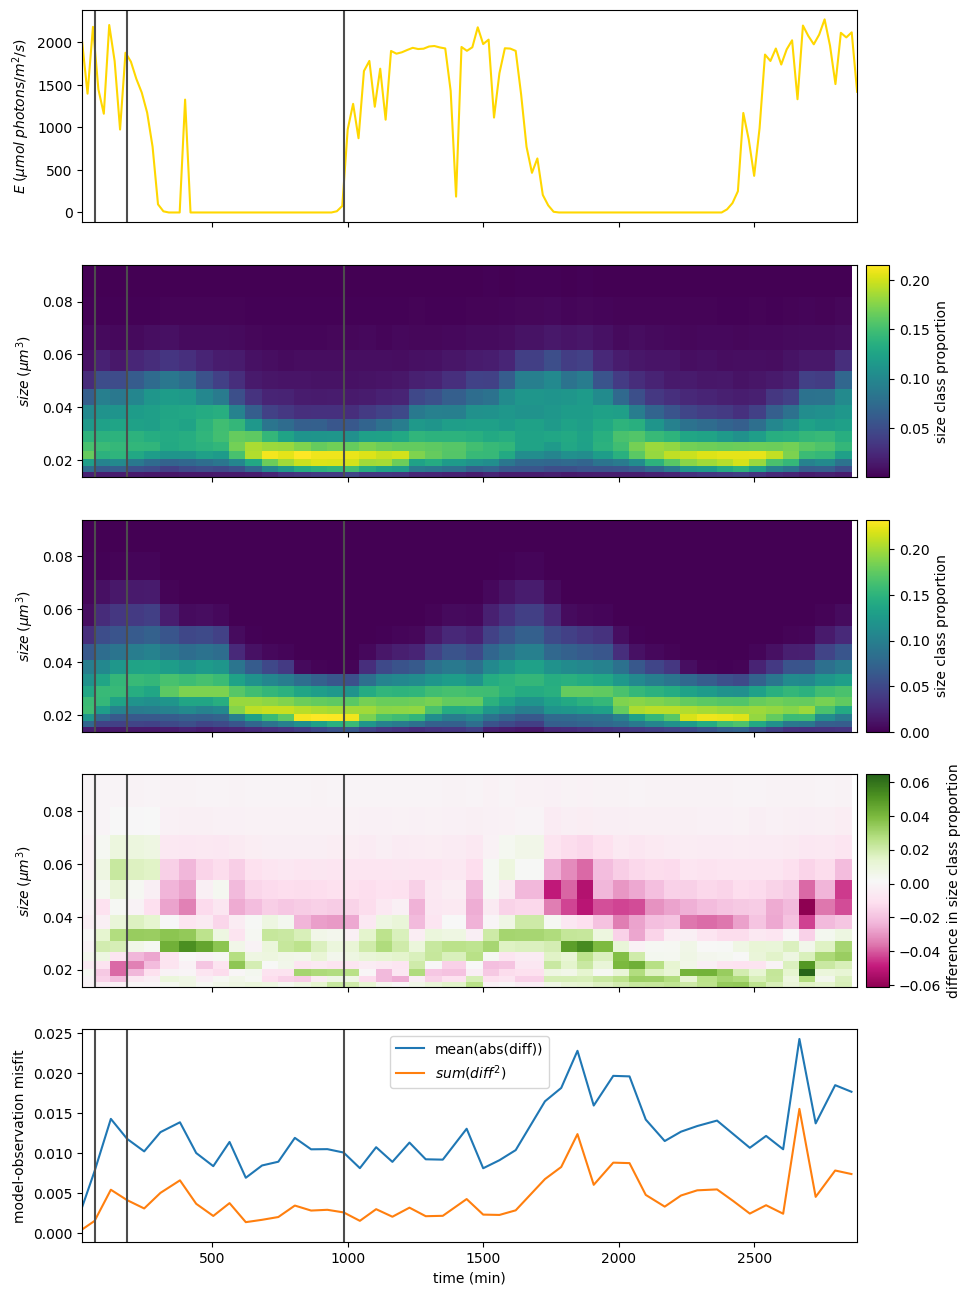

In [225]:
cm = pyimport("matplotlib.cm")
fig,axs = plt.subplots(5,1,sharex=true,figsize=(10,16))
axs[1].plot(t, data["E"], color="gold")
axs[1].set(xlim=(t[1],t[end]), ylabel=L"E\;(\mu mol\;photons/m^{2}/s)")

p2 = axs[2].pcolormesh(data["t_obs"],v,res["obs"])
axs[2].set(ylabel=L"size\;(\mu m^3)")
p2b = inset_locator.inset_axes(axs[2], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[2].transAxes)
fig.colorbar(p2,cax=p2b, pad = 0.02,label="size class proportion");

axs[3].set(ylabel=L"size\;(\mu m^3)")
p3 = axs[3].pcolormesh(data["t_obs"],v,res["model"])
p3b = inset_locator.inset_axes(axs[3], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[3].transAxes)
fig.colorbar(p3,cax=p3b, pad = 0.02,label="size class proportion");

p4 = axs[4].pcolormesh(data["t_obs"],v,diff,cmap=cm.PiYG)
axs[4].set(ylabel=L"size\;(\mu m^3)")
p4b = inset_locator.inset_axes(axs[4], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[4].transAxes)
fig.colorbar(p4,cax=p4b, pad = 0.02,label="difference in size class proportion");

prop = mean(abs.(diff),dims=1)[1,:]
axs[5].plot(data["t_obs"], prop, label="mean(abs(diff))")
prop = sum(diff.^2,dims=1)[1,:]
axs[5].plot(data["t_obs"], prop, label=L"sum(diff^2)")
axs[5].set(xlabel="time (min)", ylabel="model-observation misfit")
axs[5].legend();

slice_indices = [1,3,16].+1
for ax in axs
    for i in slice_indices
        ax.axvline(data["t_obs"][i], color=".3")
    end
end

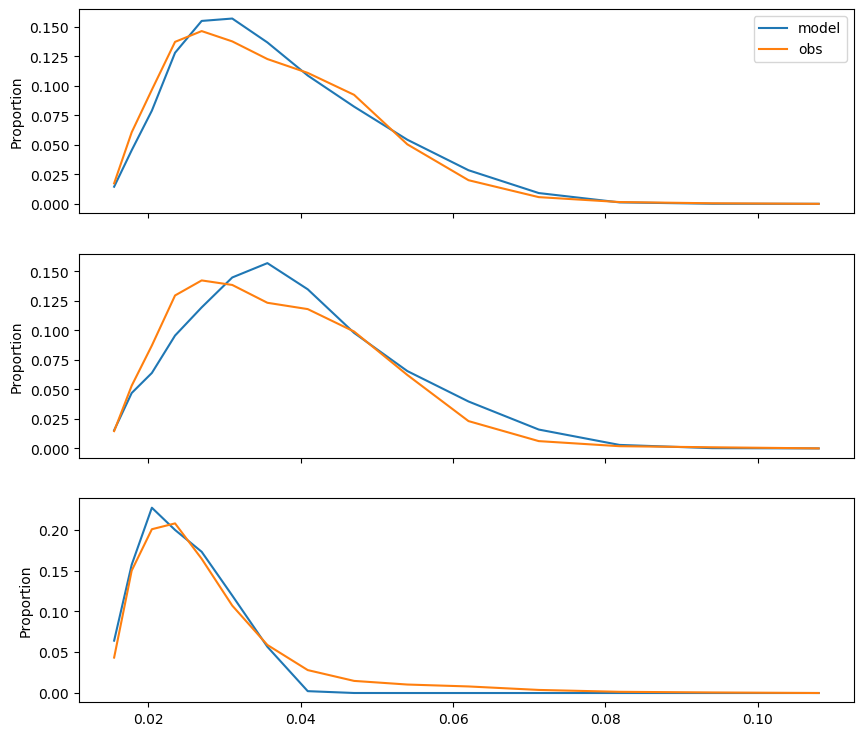

In [226]:
v_ext = data["v_min"] .* 2 .^(collect(1:1:data["m"]) .*delta_v) 
v_width = v_ext[2:end] .- v_ext[1:end-1]
fig,axs = plt.subplots(nrows=length(slice_indices), sharex=true, figsize=(10,length(slice_indices)*3))
for i in 1:length(slice_indices)
    axs[i].plot(v_ext,res["model"][:,slice_indices[i]],label = "model")
    axs[i].plot(v_ext,res["obs"][:,slice_indices[i]],label = "obs")
    axs[i].set_ylabel("Proportion")
end
axs[1].legend();